 
## Marlainna Francis Data Modeling Supervised learning Project 

***Supervised machine learning means the algorithm learns from labeled data
### Capital Bikeshare Demand Forecasting

#### The Problem/objective of the competition is to **predict total ridership of Capital Bikeshare in any given hour.**
If I can predict the quantity of demand, total ridership in a given hour, I can create analytical tools to improve the bikeshare system. 
Can I predict how many bikes will be rented in a given hour based on the weather? 

Goal is to create a High-accuracy forecasts model to help with infrastructure planning, maintenance scheduling, and ensure bike are available.

---

#### Core Q&A
**What are we predicting?** The `total_rentals` (count) per hour.

**What are the key drivers (Features)?** Weather conditions, temperature, humidity, and whether it is a working day or holiday.

**What does one row represent?** One specific hour of one day.

**Is the data clean?** Yes. I renamed the target variable to `total_rentals` to avoid coding conflicts and ensured the `datetime` index was properly formatted for time-series analysis.

---

## The Results



* **Temperature Impact:** For every **1°C increase** in temperature, we see an average increase of **9.17 rentals**.
* **Baseline Demand:** Even at **0°C**, the model predicts a baseline of approximately **6 rentals** per hour.

---

## Technical Workflow

### 1. Exploration
Visualized correlations using **Seaborn heatmaps** and scatter plots to identify the strongest predictors of demand.



### 2. Modeling
Built a **Linear Regression** model using **Scikit-Learn**. I chose this model for its high interpretability and efficiency in forecasting continuous numerical values.

### 3. Validation
Interpreted coefficients ($\beta_1$) and intercepts ($\beta_0$) to ensure the model aligns with real-world logic and business intuition.

 
 

<a id="introduce-the-bikeshare-dataset"></a>
## Import Libraries
---

In [1]:
# Standard imports
import pandas as pd
import numpy as np

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# Specific imports
# These are new! Notice we're using the 'from' approach to import only what we need.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Statistics imports
from scipy import stats
import statsmodels.api as sm

# magic and parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data into a Pandas DataFrame.

In [2]:
# Read the data and set the datetime as the index.
url = './data/bikeshare.csv'
bikes_df = pd.read_csv(url, index_col='datetime', parse_dates=True)

use `index_col` to set an index or primary key for the data. Index of each row will be set to the value of its `datetime` field.

Parse dates using parse_dates=True for the index only.  Pandas converts the index string to a `datetime` object.

### Inspect Data

In [3]:
# Preview the first five rows of the DataFrame.
bikes_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### What does each observation represent?

Each observation (row) represents one specific hour of bike rentals.  The response variable (the "target") is the count column.
There are 9 primary features available to predict the rental count:
* Categorical/Binary: season, holiday, workingday, and weather.
* Numerical: temp, atemp ("feels like"), humidity, and windspeed.
* Excluded Variables: casual and registered are usually not used as features because they sum up to the target count.


#### What is the response variable?

count column

#### How many features are there?

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See Below|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

> _Details on Weather Variable_

> **1**: Clear, Few clouds, Partly cloudy, Partly cloudy

> **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

<a id="overview-of-supervised-learning"></a>
## Rename Target column to total_rentals
---



In [4]:
# Use the .rename() method to rename count to total
bikes_df.rename(columns={'count':'total_rentals'}, inplace=True)
bikes_df.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


<a id="visualizing-the-data"></a>
### Visualizing the Data

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

**View the distribution of total rentals using plot method**

<Axes: xlabel='datetime'>

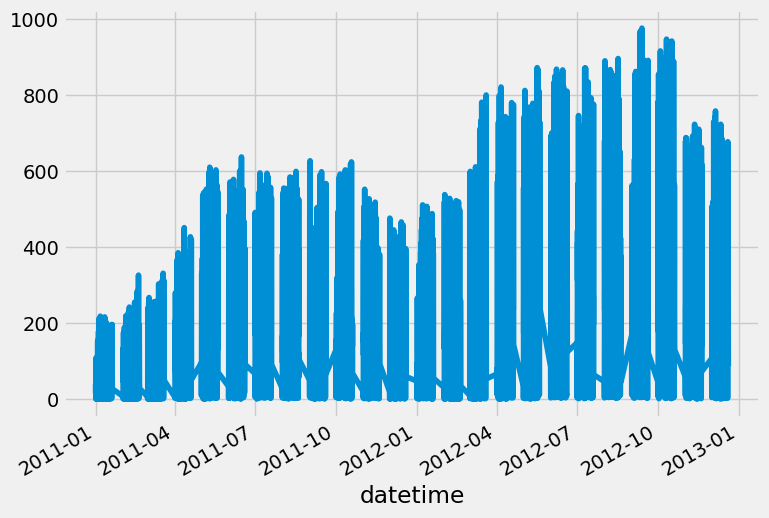

In [5]:
# What method should we use to visualize this data?
bikes_df['total_rentals'].plot()  # what goes here

**View variable correlations using heatmap**

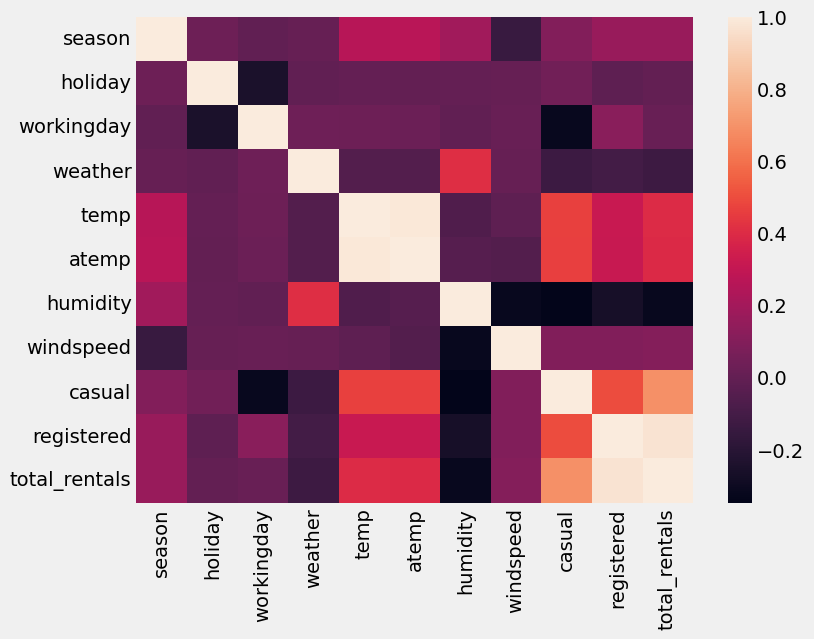

In [6]:
sns.heatmap(bikes_df.corr());

The heatmap confirms that temperature and humidity are critical features to include in your Linear Regression. However, because temp and atemp are so similar, including both could violate the "Low to No Multicollinearity" assumption of linear regression.

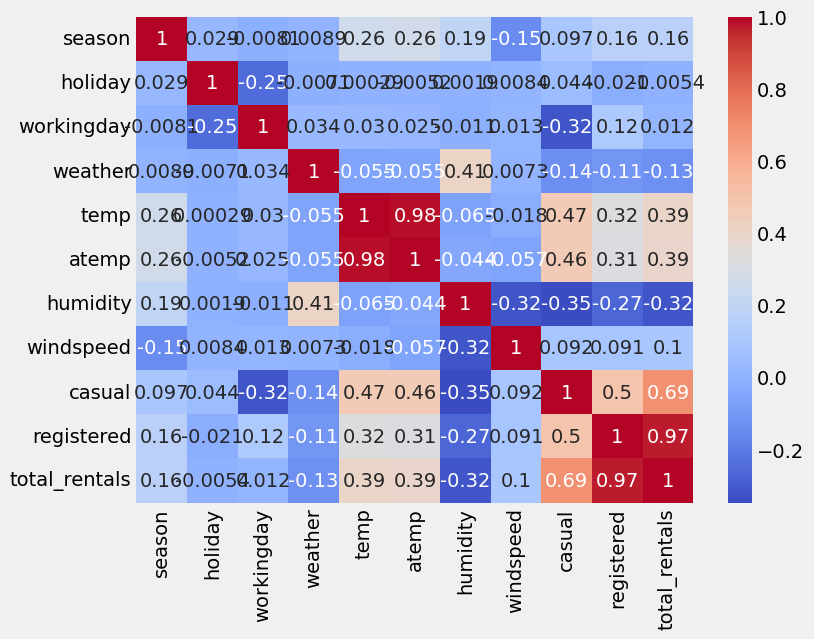

In [7]:

sns.heatmap(bikes_df.corr(),cmap='coolwarm',annot=True)
plt.rcParams['figure.figsize'] = (20, 20)
 

This correlation map helps identify which factors most influence bike rentals and where variables might be redundant.

**Variable relationships using a scatter plot**

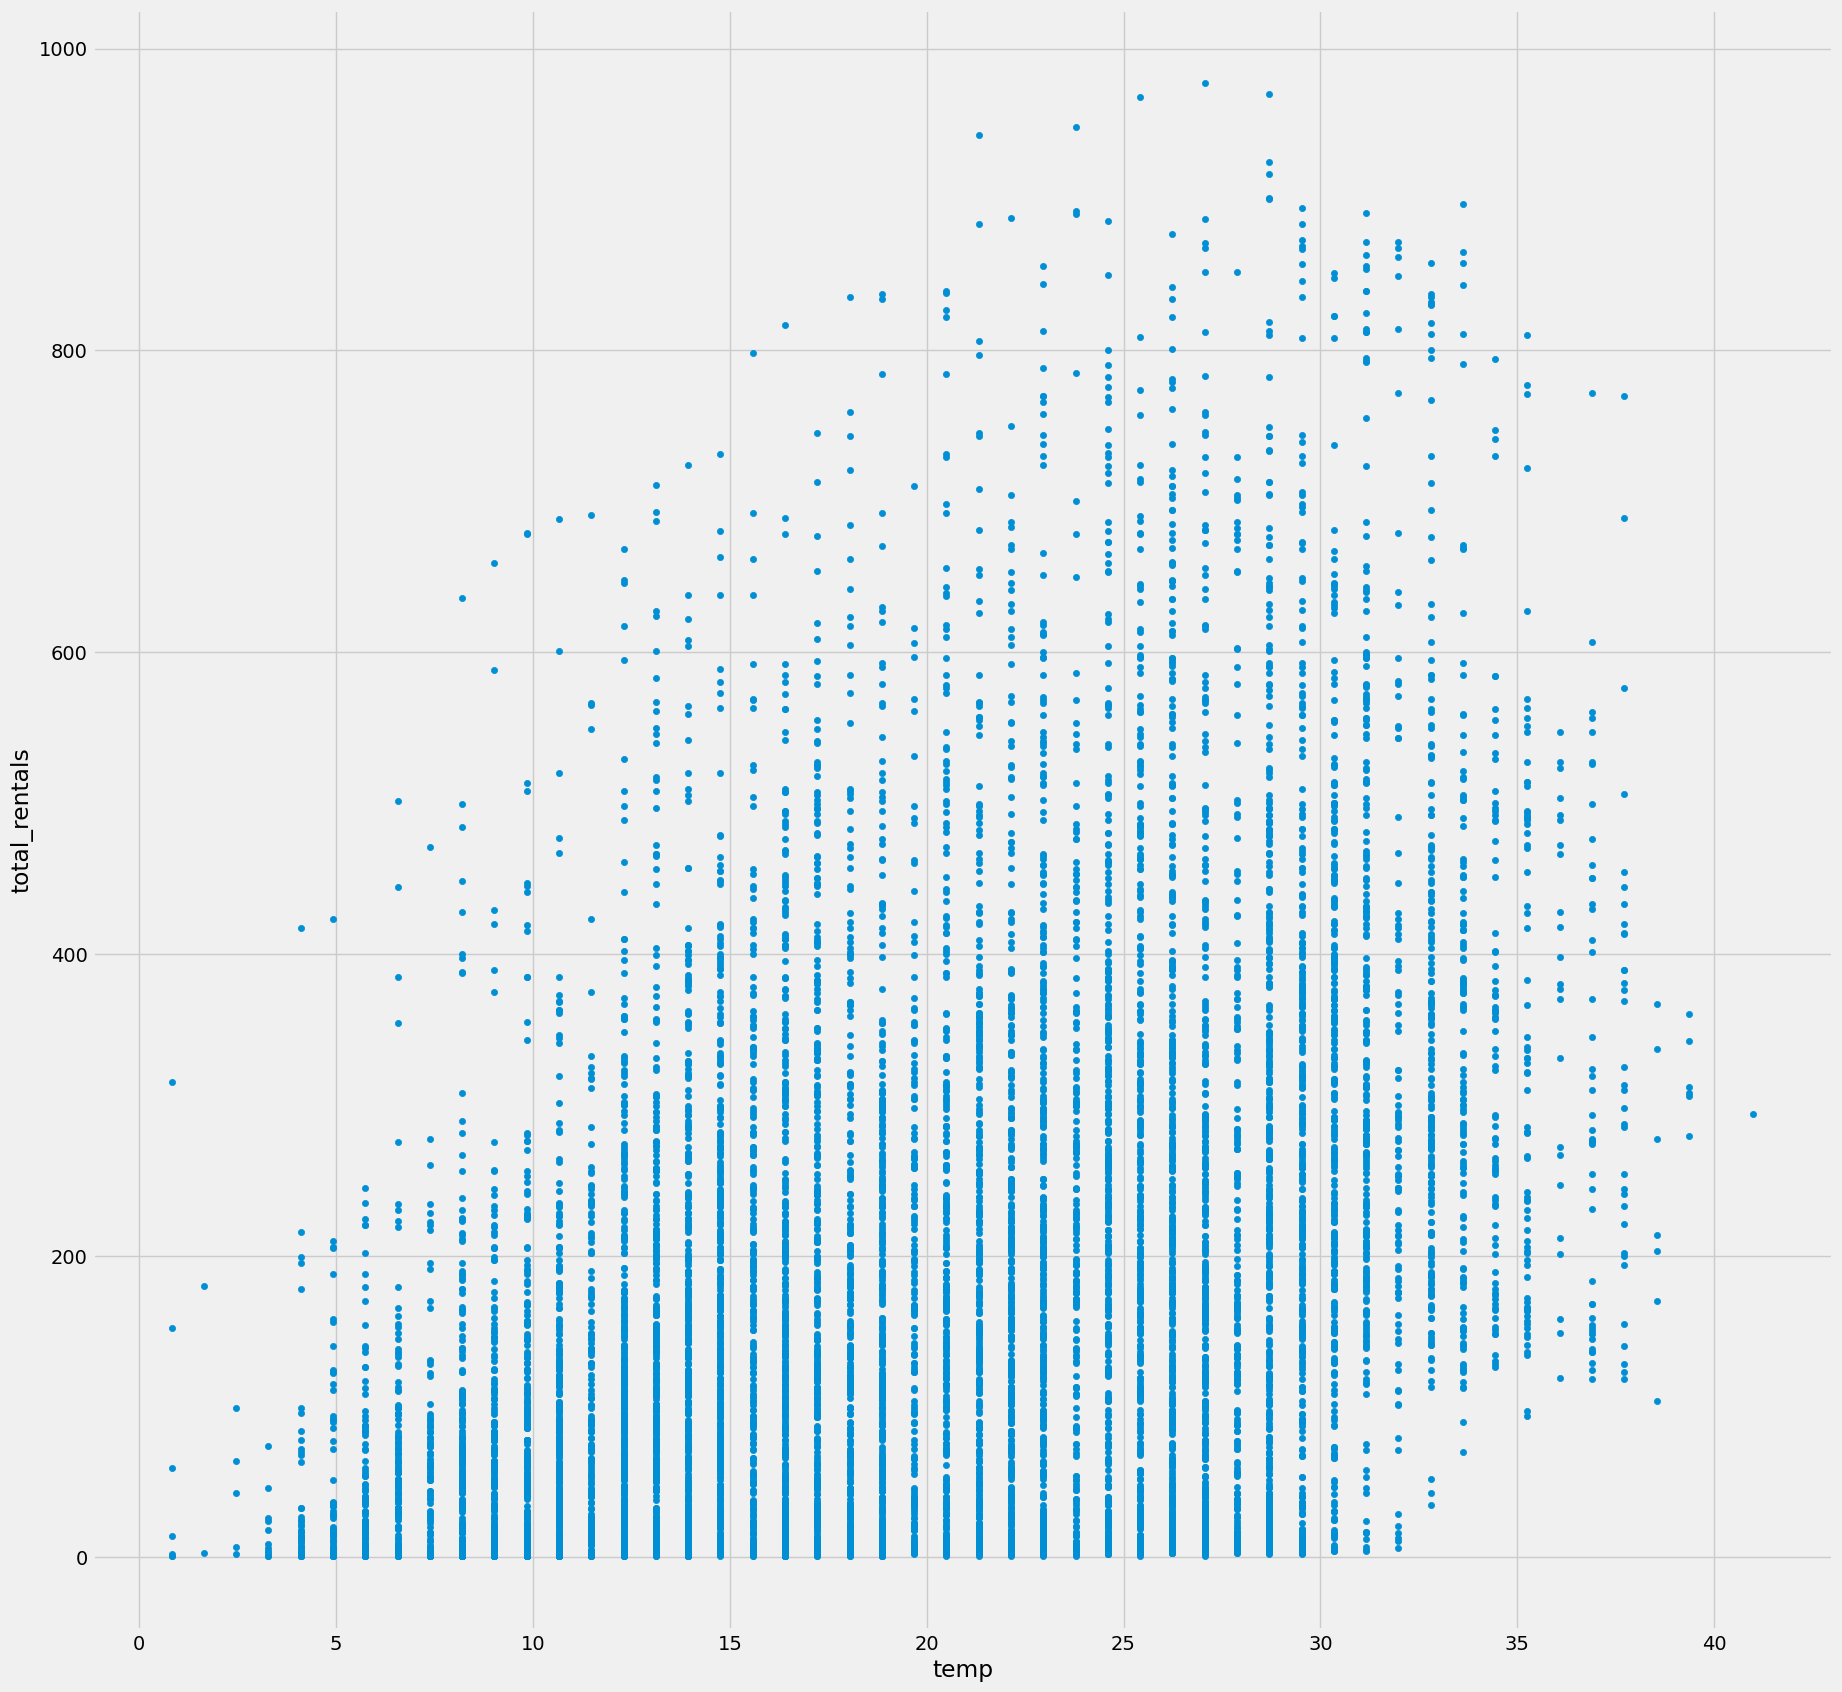

In [8]:
# Pandas scatterplot
bikes_df.plot(kind='scatter', x='temp', y='total_rentals');

Positive Linear Trend: Generally, as the temperature increases, the number of total rentals also increases. This aligns with your heatmap

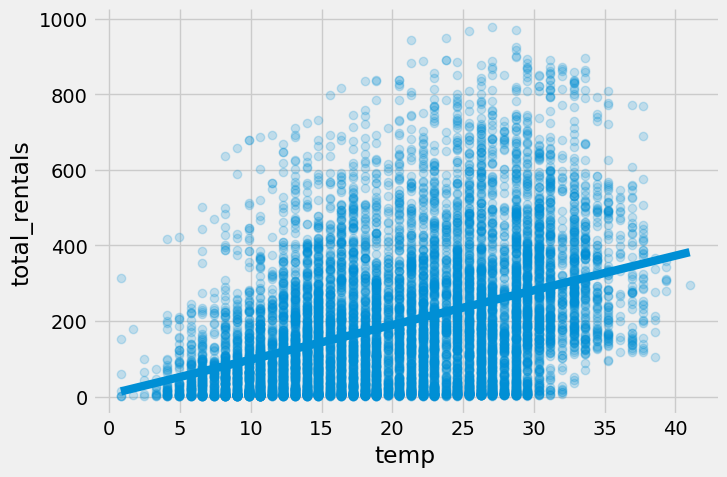

In [9]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp', y='total_rentals', data=bikes_df, aspect=1.5, scatter_kws={'alpha':0.2});

Positive Linear Trend: Generally, as the temperature increases, the number of total rentals also increases. This aligns with your heatmap

<a id="linear-regression-basics"></a>
## Linear Regression 
---

<a id="building-a-linear-regression-model-in-sklearn"></a>
### Building a Linear Regression Model in sklearn

#### Create a feature matrix called X that holds a `DataFrame` with only the temp variable and a `Series` called y that has the "total_rentals" column.

In [10]:
# Create X and y.
feature_cols = ['temp']
X = bikes_df[feature_cols]
y = bikes_df['total_rentals']

In [11]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [12]:
X

,temp
datetime,
2011-01-01 00:00:00,9.84
2011-01-01 01:00:00,9.02
2011-01-01 02:00:00,9.02
2011-01-01 03:00:00,9.84
2011-01-01 04:00:00,9.84
...,...
2012-12-19 19:00:00,15.58
2012-12-19 20:00:00,14.76
2012-12-19 21:00:00,13.94


In [13]:
#Array, strips all the panda metaframe.
#
X.values

array([[ 9.84],
       [ 9.02],
       [ 9.02],
       ...,
       [13.94],
       [13.94],
       [13.12]], shape=(10886, 1))

In [14]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [15]:
# Check X's shape (n = number of observations, p = number of features).
print((X.shape))

(10886, 1)


In [16]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(10886,)


Note: the shape for X and Y must be the same number of rows

<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

**Step 1:** Import the class you plan to use. <br> --from sklearn.linear_model import LinearRegression
**Step 2:** "Instantiate" the "estimator." <br>
**Step 3:** Fit the model with data (aka "model training"). <br>
**Step 4:** Predict the response for a new observation. <br>
<br>
<br>
<br>
**Step 1:** **Import the class/module/method you plan to use.**

**Step 2:** **"Instantiate" the "estimator."**

- "Estimator" is scikit-learn's term for "model."
- "Instantiate" means "make an instance of."

In [17]:
# Make an instance of a LinearRegression object.
# Instantiate the LR Object
lr = LinearRegression()
type(lr)

sklearn.linear_model._base.LinearRegression

**Step 3:** **Fit the model with data (aka "model training").**

- Model is "learning" the relationship between X and y in our "training data."
- Process through which learning occurs varies by model.
- Occurs in-place.

In [18]:
# Fit the model
lr.fit(X, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [19]:
# Print the coefficients - Why is this a list?
print(f'coefficients: {lr.coef_}')

# Print the intercept.
print(f'intercept: {lr.intercept_}')

coefficients: [9.17054048]
intercept: 6.046212959616412


Interpreting the intercept ($\theta_0$):


formula for a line:

y=mx+b

or y = ($\theta_1$) x + ($\theta_0$):
 
In the literature for machine learning it's often written as follows: 
. In this formulation 
 is called a weight instead of a coefficient and 
 is called a bias instead of intercept.


- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\theta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\theta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in total rentals.
- $\theta_1$ would be **zero** if temperature is not associated with total rentals.

In [20]:
dict(zip(X.columns, lr.coef_))

{'temp': np.float64(9.170540481426254)}

- Once a model has been fit with data, it's called a "fitted model."

**Step 4:** Predict the response for a new observation.

- New observations are called "out-of-sample" data.
- Uses the information it learned during the model training process.

In [21]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
# Create a tiny dataframe with the feature name 'temp'
X_new = pd.DataFrame({'temp': [0]})

# Predict using the dataframe
lr.predict(X_new)

#grab the first array of 0 lenght and reshap it to a list of list
#lr.predict( np.array([0]).reshape(1,-1) )

array([6.04621296])

Let's ask the model to make two predictions, one when the `temp` is 0 and another when the `temp` is 10. To do this, our feature matrix is always a 2-D array where each row is a list of features. Since we only have a single feature, the temperature, each row will contain only a single value.

In [22]:
X_new = pd.DataFrame({'temp': [0, 10, 20, 200]})
lr.predict(X_new)

array([   6.04621296,   97.75161777,  189.45702259, 1840.15430924])

In [23]:
temp = 0
print( 9.170540481426237 *(temp) + 6.04621296)

6.04621296


What we just predicted using our model is, "If the temperature is 0 degrees, the total number of bike rentals will be ~6.046. . As the temperature rises from this point, you simply add 9.17 rentals for every additional degree of warmth.

In [24]:
# load the data into a dataframe named lv_reviews
path = './data/LasVegasTripAdvisorReviews-Dataset.csv'

lv_reviews = pd.read_csv('./data/LasVegasTripAdvisorReviews-Dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/LasVegasTripAdvisorReviews-Dataset.csv'

In [ ]:
# display the first 2 rows of lv_reviews
lv_reviews[ :2]

**Create a correlation matrix and clustermap of the variables.**

In [ ]:
corr = None

sns.clustermap(lv_reviews.corr(),annot= True, cmap = 'viridis');

**Display the distribution of the Score variable using a histogram.**

In [ ]:
lv_reviews['Score'].hist()

**Create X and y using Hotel stars as the X variable and Score as the y variable.**

In [ ]:
feature_cols = ['Hotel stars']
X =lv_reviews[['Hotel stars']]  #x must be a dataframe anther way X = lv_reviews[feature_cols]
y =lv_reviews['Score']          #series

#### Instantiate and fit a `LinearRegression` model on X and y from the `linear_model` section of scikit-learn.
Be sure to use the scikit-learn "recipe."

In [ ]:
# Instantiate and fit a linear regression
# Import, instantiate, fit.
#from sklearn.linear_model import LinearRegression # already imported

linreg = LinearRegression()
linreg.fit(X, y)
 




**Print the coefficients and intercept.**

In [ ]:
# print the coefficients and intercept. In your printed output be sure to identify them appropriate

#Result: They are positively related

# print(linreg.intercept_)
# print(linreg.coef_)

# Print the coefficients - Why is this a list?
print(f'coefficients: {linreg.coef_}')

# Print the intercept.
print(f'intercept: {linreg.intercept_}')

**Interpret the coefficients and intercept.**

Interpreting the intercept ($\theta_0$):

- It is the value of $y$ when all independent variables are 0.
- The estimated score when the hotel has 0 stars.
- **Note:** This is a case where the intercept would not be sensible, but it is still important to score observations.

Interpreting the "Hotel stars" coefficient ($\theta_1$):

- **Interpretation:** An increase of 1 star is _associated with_ increasing the user score by $\theta_1$.
- Here, a temperature increase of 1 star is _associated with_ a predicted increase of 0.187 in the score.
- This is not a statement of causation.

<a id="using-the-model-for-prediction"></a>
## Using the Model for Prediction 
---

While plenty of insight can be found in reading coefficients, the most common uses of data science focus on prediction. In scikit-learn we can make predictions from a fitted model using `.predict()`, but we will also go through the calculation by hand to understand it.

#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

#### Explore the intercept and coefficients of the linear model.

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [25]:
# Manually calculate the prediction.
lr.intercept_+lr.coef_*25
#6.04621295961681+9.17054048*25

array([235.309725])

In [26]:
print(lr.intercept_)
print(lr.coef_)

6.046212959616412
[9.17054048]


In [27]:
# Use the predict method.
# 1. Create a DataFrame with the column name used during training
X_new = pd.DataFrame({'temp': [0, 1, 25]})

# 2. Use the predict method (no warning will appear)
print(lr.predict(X_new))

[  6.04621296  15.21675344 235.309725  ]


<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [28]:
# Create a new column for Fahrenheit temperature.
bikes_df['temp_F'] = bikes_df['temp'] * 9/5 + 32
bikes_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


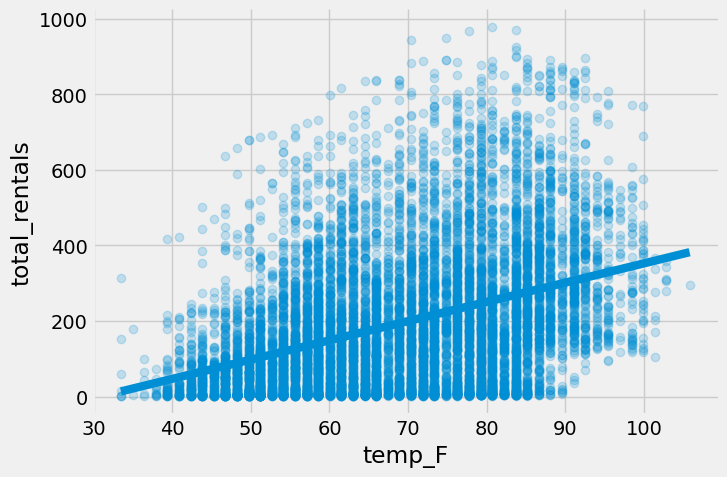

In [29]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp_F', y='total_rentals', data=bikes_df, aspect=1.5, scatter_kws={'alpha':0.2});

#### Rebuild the `LinearRegression` from above using the `temp_F` features instead.

In [30]:
# Create X and y.
feature_cols = ['temp_F']
X = bikes_df[feature_cols]
y = bikes_df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-156.985617821292
[5.09474471]


#### Convert 25 degrees Celsius to Fahrenheit.

In [31]:
# A function to convert Celsius to Fahrenheit temperature scale

def celsius_fahrenheit(temp, cflag=True):
    """convert temperature from celsius to fahrenheit or fahrenheit to celsius

        Uses the formula:
                    F = C*1.8 + 32
                    C = (F-32)/1.8
                    
    Args: temp: temperature in celsius or fahrenheit as an int or float
          cflag: boolean, if true convert C-F, if false convert F-C
    
    Returns: converted temperature"""
    
    if cflag:
        new_temp = temp*1.8 + 32
    else:
        new_temp = (temp - 32)/1.8
        
    return new_temp

assert celsius_fahrenheit(77, False) == 25

In [32]:
F = celsius_fahrenheit(25)
F

77.0

#### Predict rentals for 77 degrees Fahrenheit.

In [33]:
# Create a small DataFrame with the correct feature name
X_new = pd.DataFrame({'temp': [25]})

# Predict using the DataFrame instead of a list
prediction = lr.predict(X_new)

print(f'25 Degrees Celsius Prediction {prediction} bikes rented')

25 Degrees Celsius Prediction [235.309725] bikes rented


In [34]:
# Create a small DataFrame with the correct feature name
X_new = pd.DataFrame({'temp': [77]})

# Predict using the DataFrame instead of a list
prediction = lr.predict(X_new)

print(f'77 Degrees Celsius Prediction {prediction} bikes rented')

77 Degrees Celsius Prediction [712.17783003] bikes rented


**Conclusion:** The scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

In [35]:
# Remove the temp_F column.
bikes_df.drop('temp_F', axis=1, inplace=True)

<a id="work-with-multiple-features"></a>
## Work With Multiple Features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once. There is no limit to the number of features you can use. However, often a small set of features accounts for most of the variance (assuming there is a linear relationship at all). We will start by using four features.

<a id="visualizing-the-data-part-"></a>
### Visualizing the Data (Part 2)

#### Explore more features.

In [36]:
# Create feature column variables
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the y_vars argument to only show relationships with the `total_rentals` variable

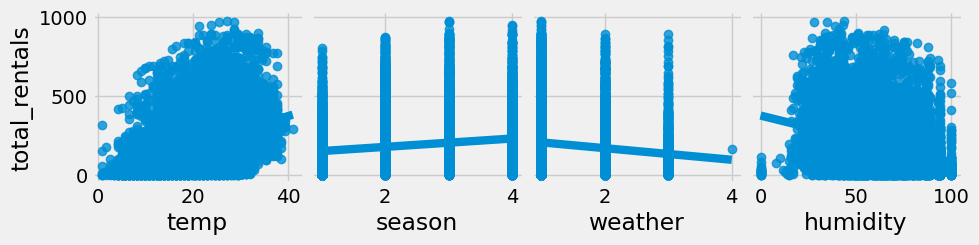

In [37]:
# multiple scatterplots in Seaborn
sns.pairplot(bikes_df, x_vars=feature_cols, y_vars='total_rentals', kind='reg');

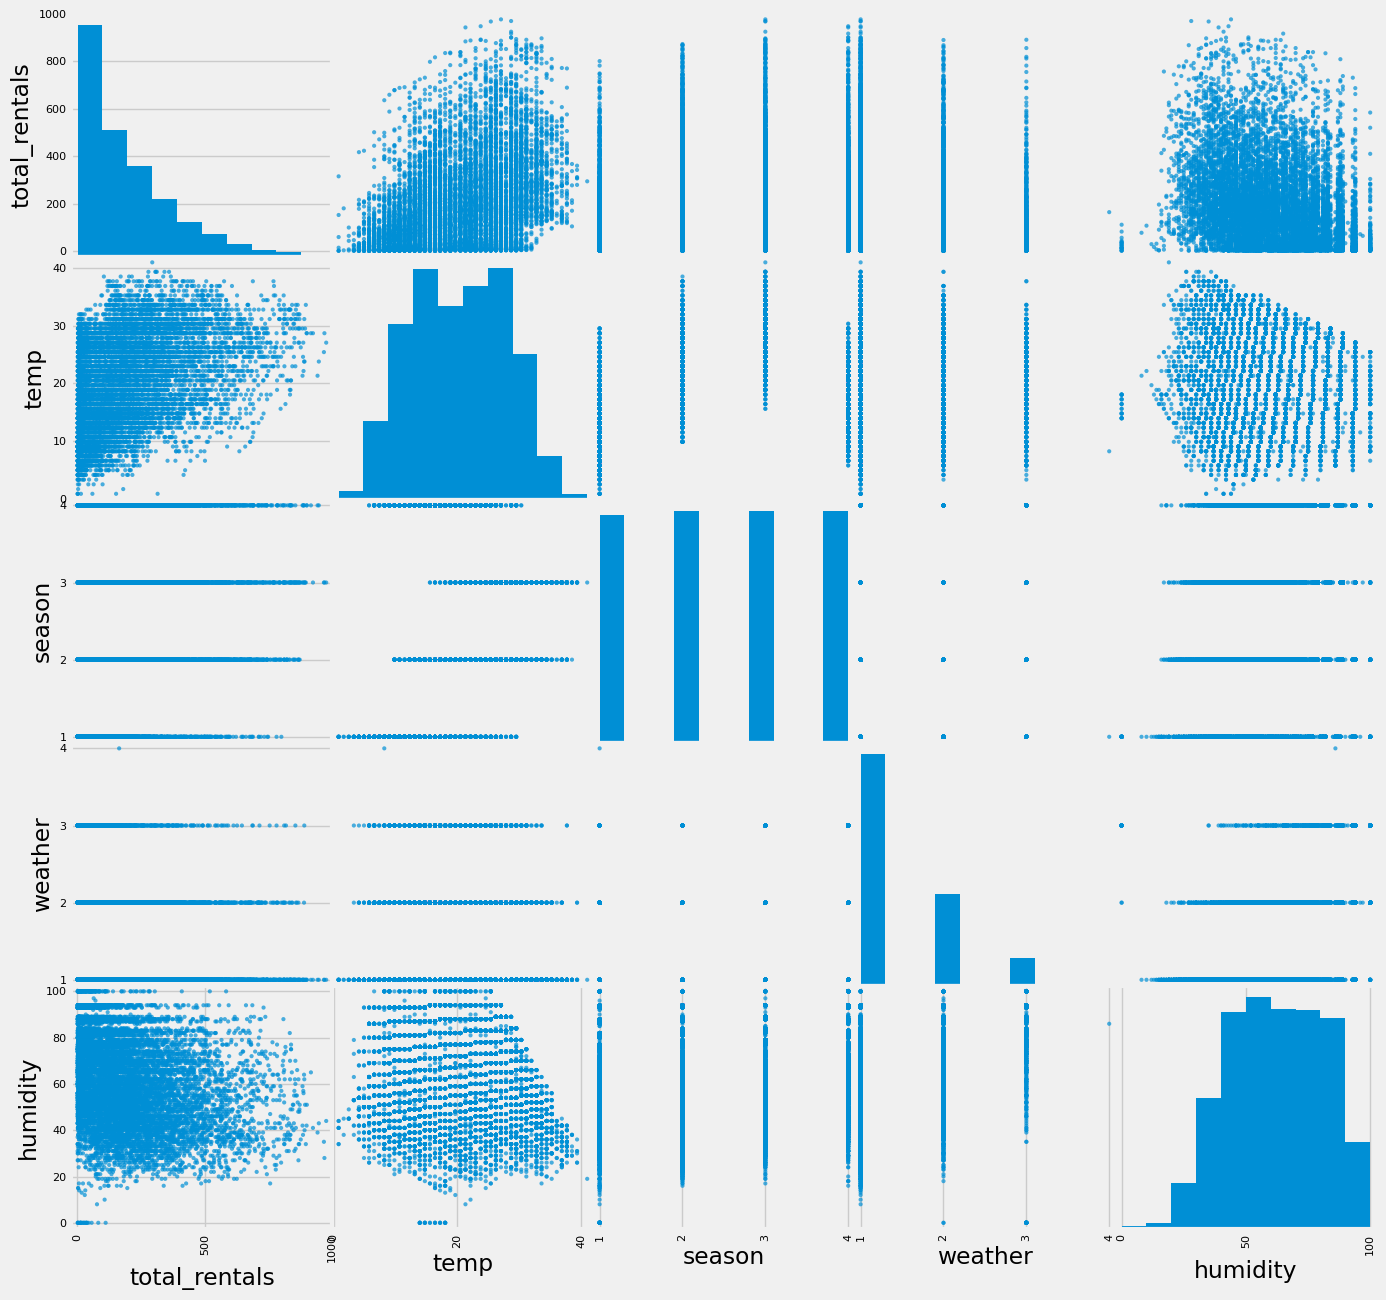

In [38]:
# alternative way in Pandas (might take a while)
# scatter_matrix does a pairplot of *every* column

grr = pd.plotting.scatter_matrix(bikes_df[['total_rentals'] + feature_cols], figsize=(15, 15), alpha=0.7)

#### Are you seeing anything you didn't expect?

#### Explore the season variable using a cross-tab.
**From the docstring**: "Compute a simple cross tabulation of two (or more) factors. By default
computes a frequency table of the factors unless an array of values and an
aggregation function are passed."

In [39]:
# Cross-tabulation of season and month
pd.crosstab(bikes_df['season'], bikes_df.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


#### Explore the season variable using a box plot.

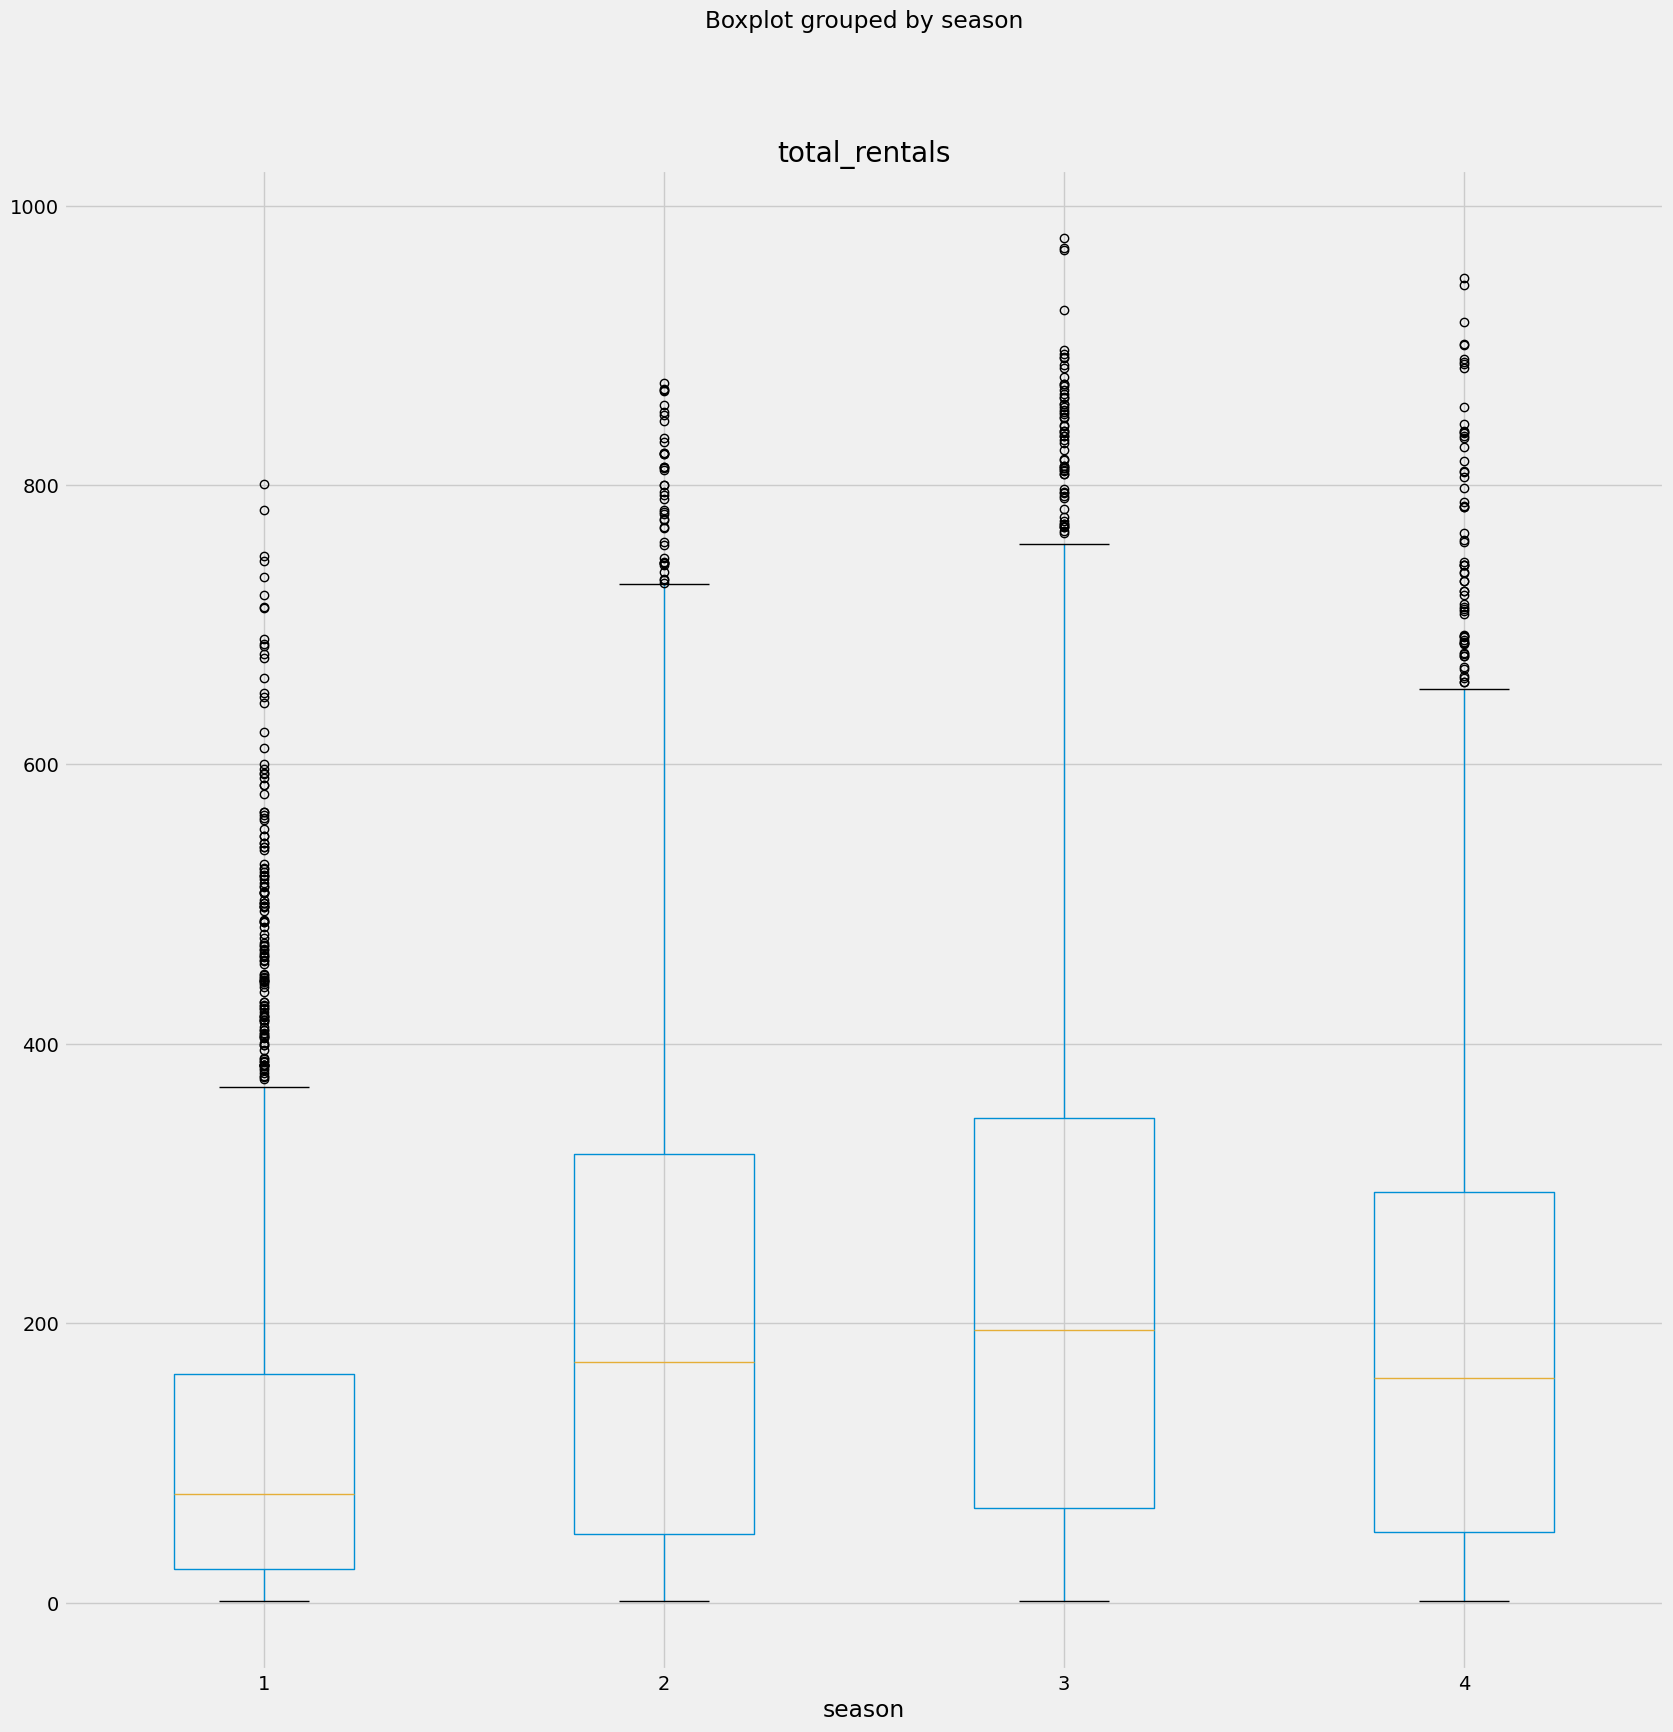

In [40]:
# Box plot of rentals, grouped by season
bikes_df.boxplot(column='total_rentals', by='season');

#no one is going out side during the first quarter
#black line means there a number or rows between 400 - 800 that are outlines but it doesnt happen enough to be not 
#considered an outliner

#### Look at rentals over time.

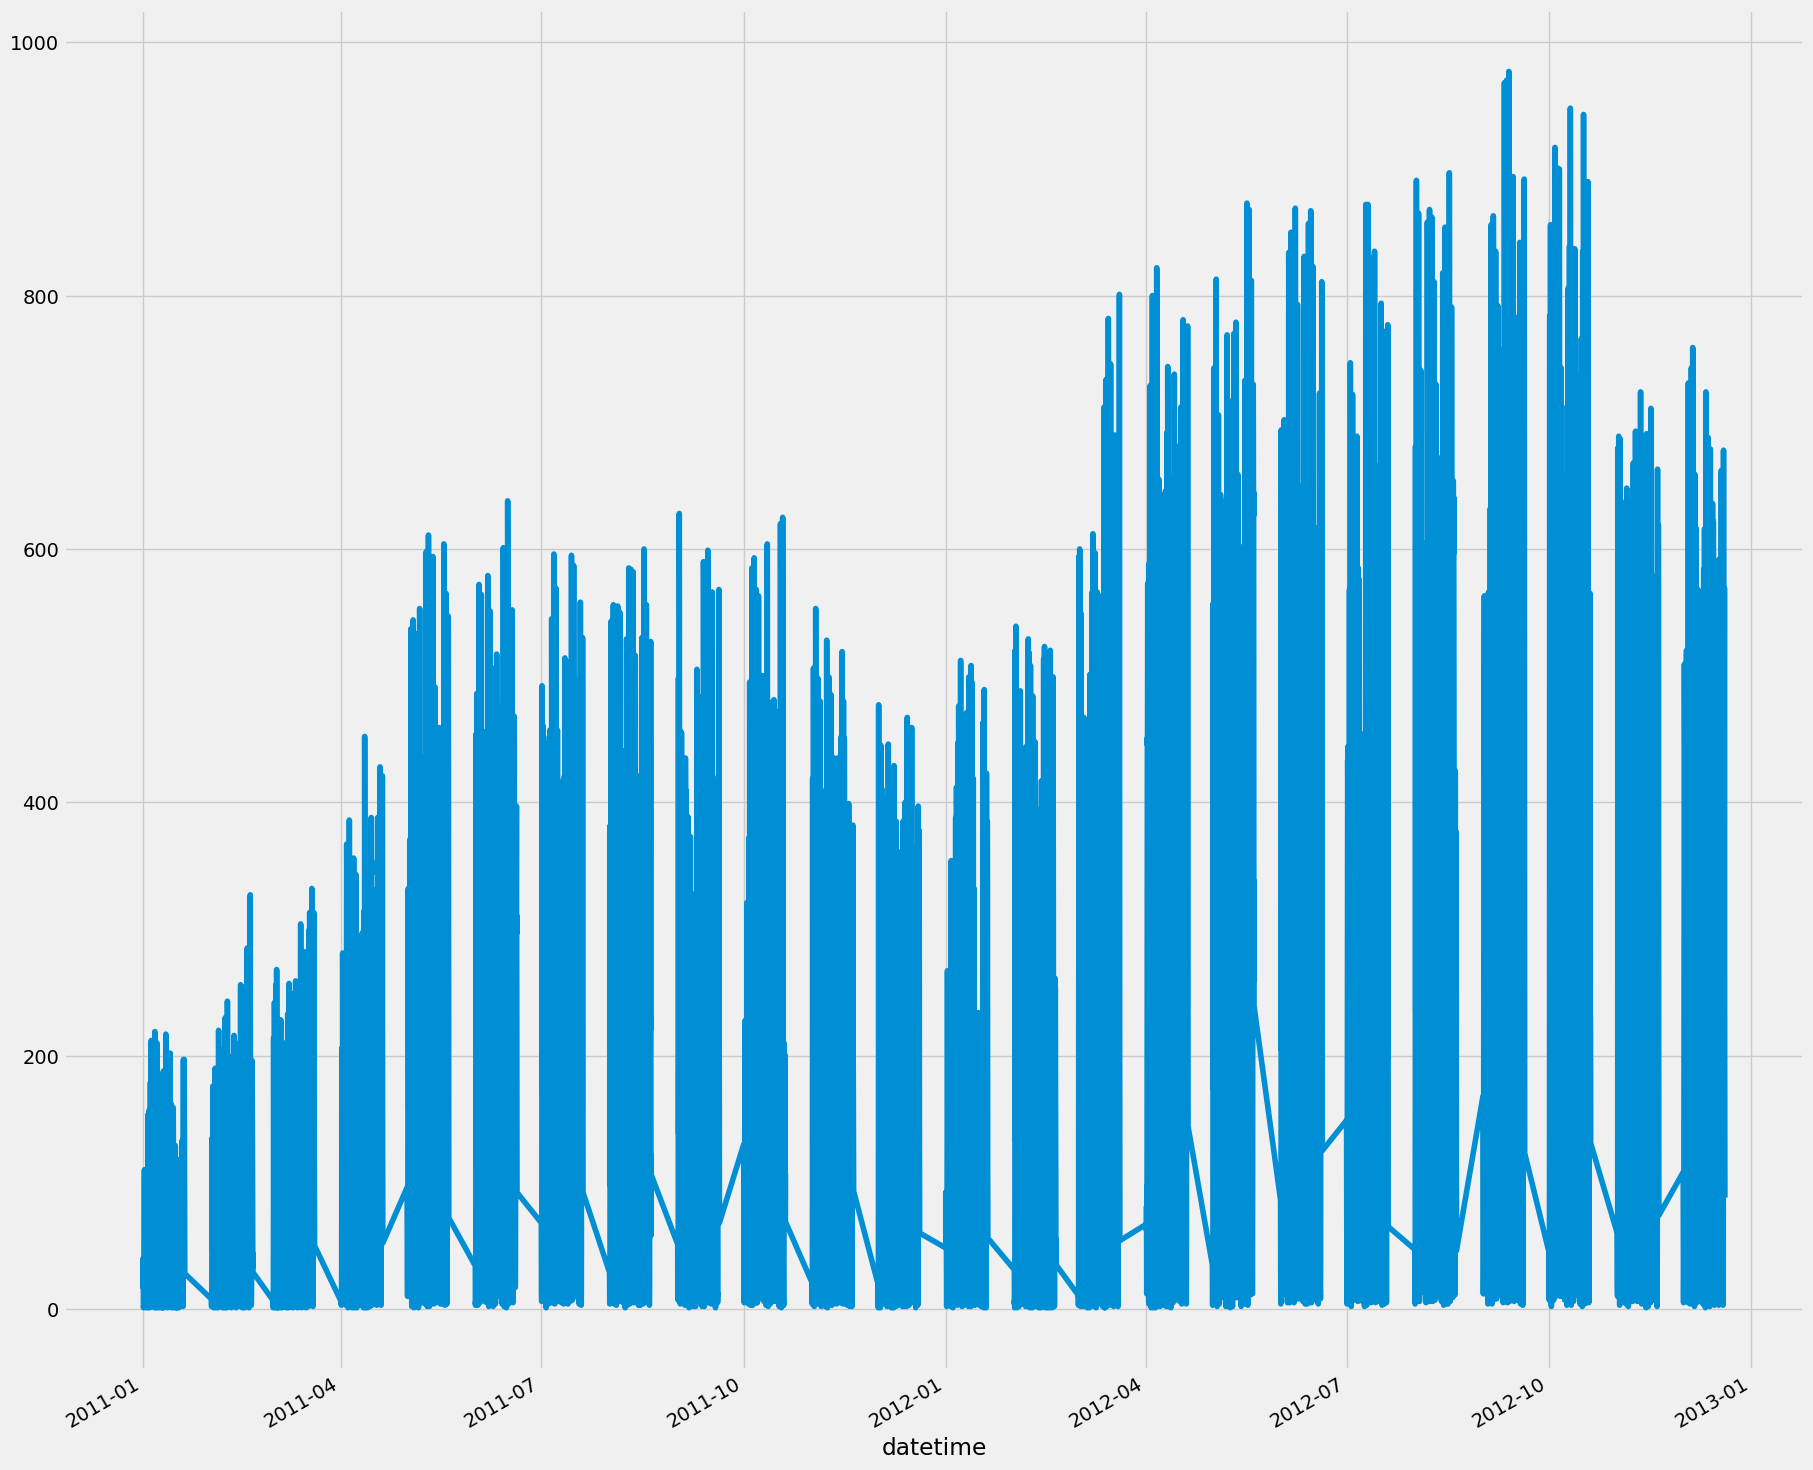

In [41]:
# Line plot of rentals
bikes_df['total_rentals'].plot();

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

#### Look at the correlation matrix for the bikes `DataFrame`.

In [42]:
# Correlation matrix (ranges from 1 to -1)
bikes_df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


#### Use a heat map to make it easier to read the correlation matrix.

<Axes: >

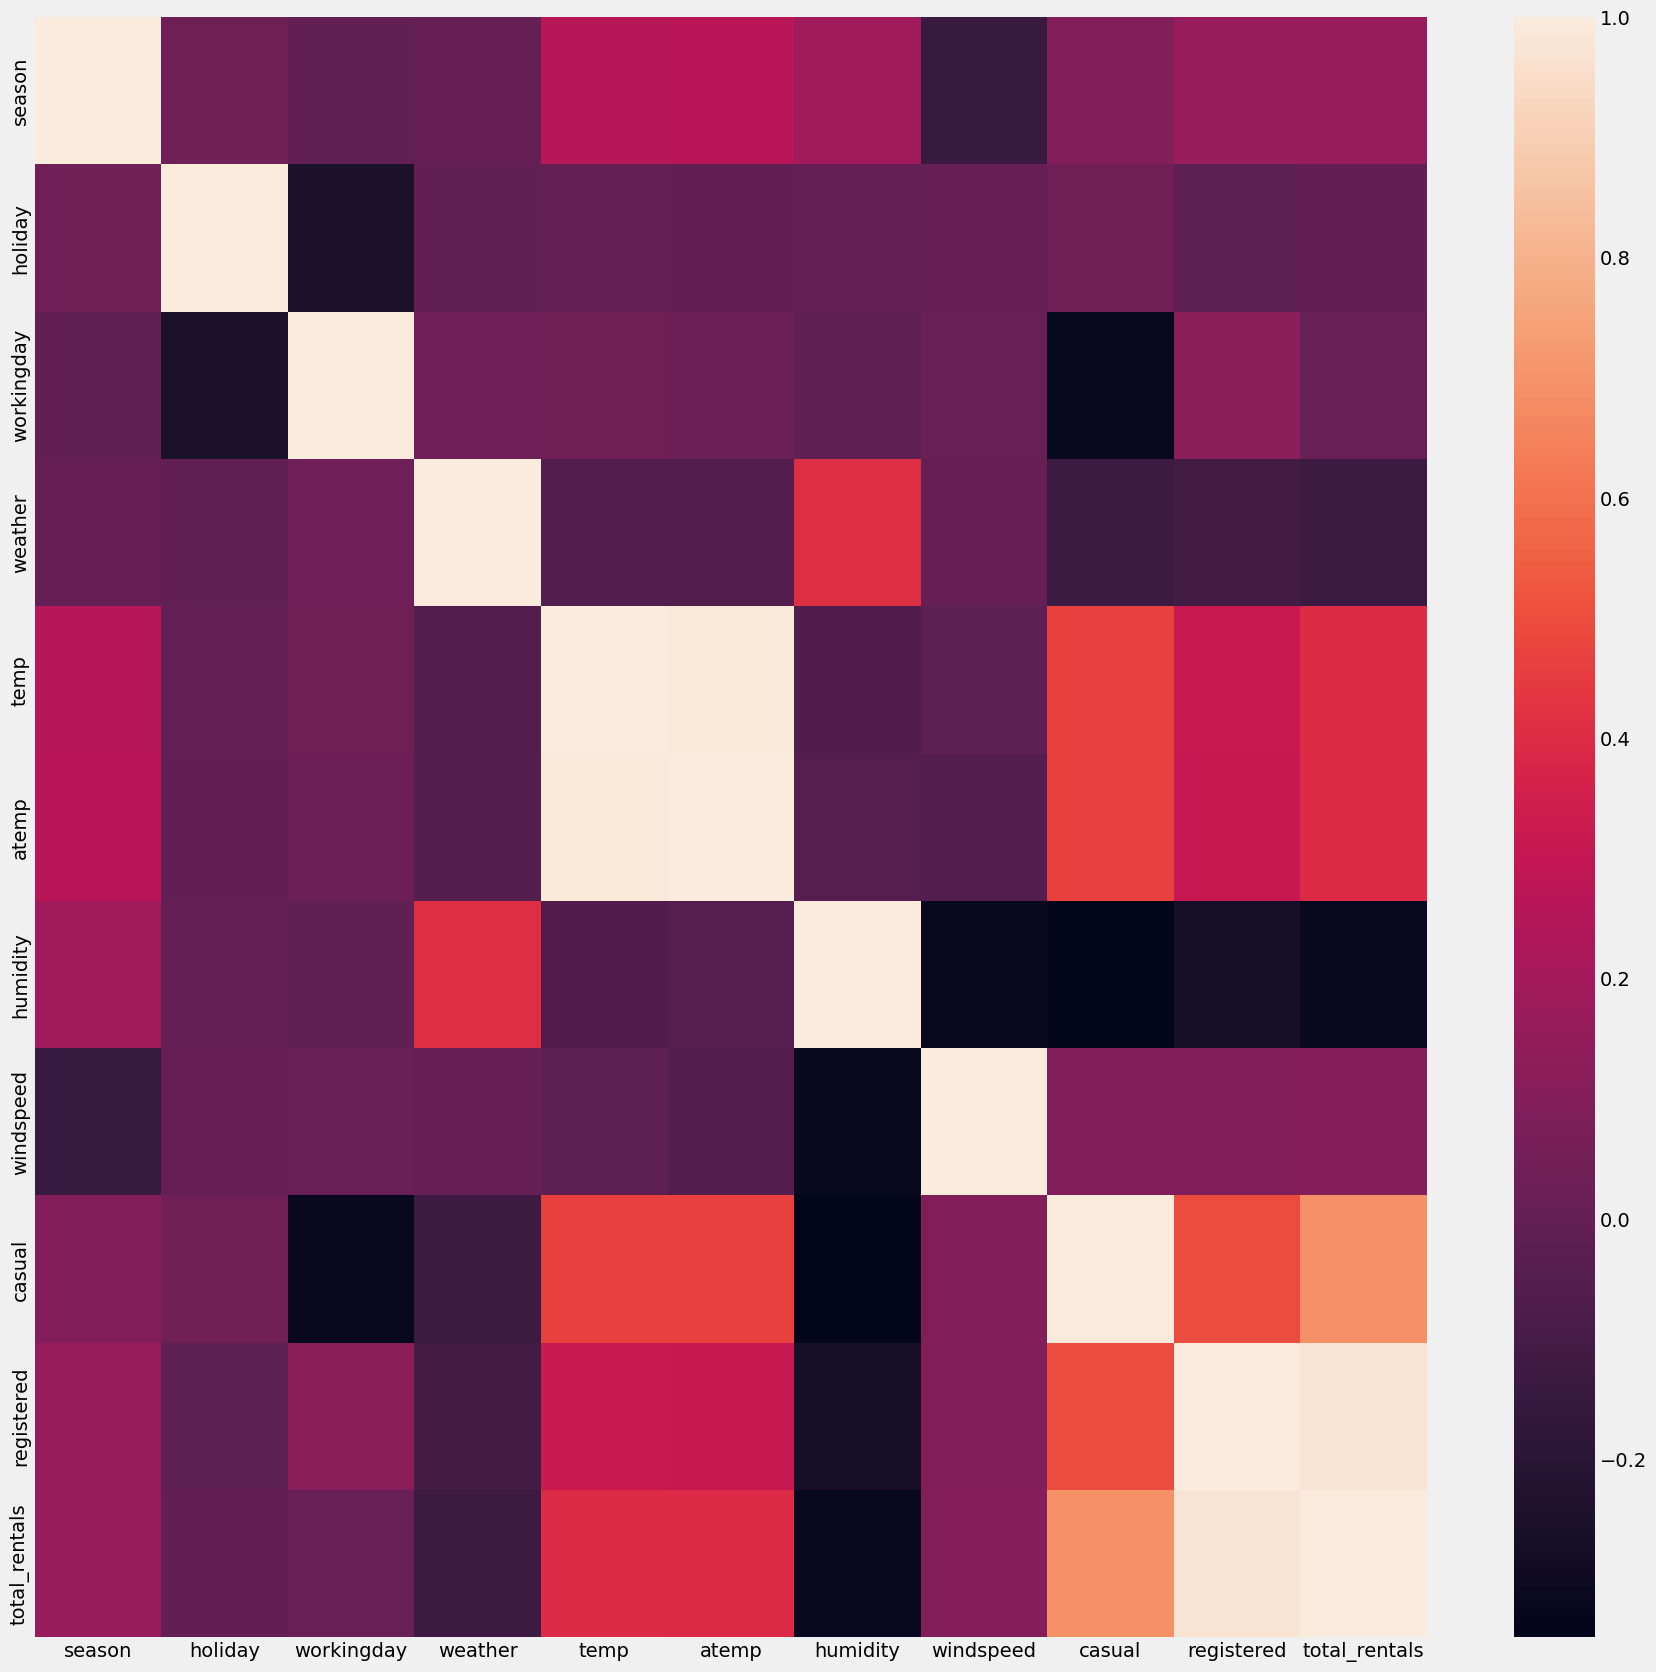

In [43]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes_df.corr())

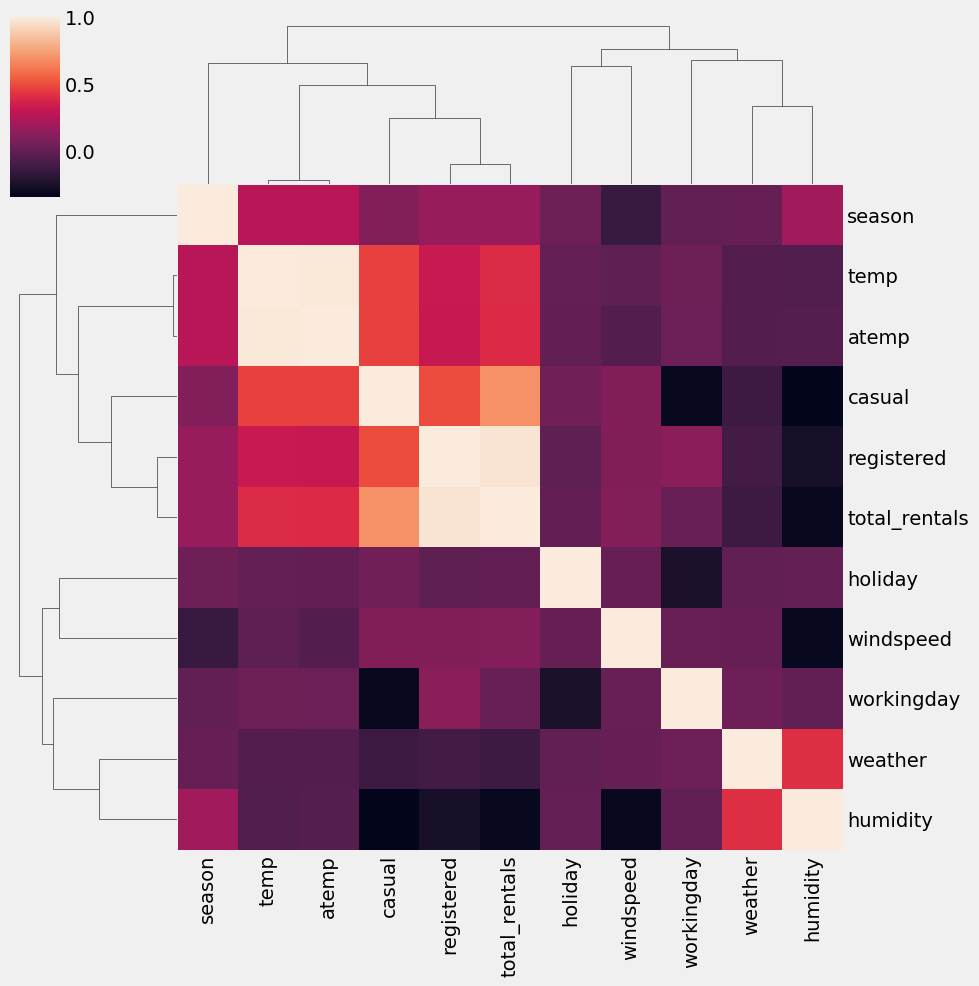

In [44]:
sns.clustermap(bikes_df.corr());

#### What relationships do you notice?

In [45]:
# A:

Why would you not include `temp` and `atemp` together even though they are the closest related to `total_rentals`?

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of one another, but all of them should help explain the y variable.

#### Create another `LinearRegression` instance that is fit using temp, season, weather, and humidity.

In [46]:
# Create a list of features.
#lets build a model with these features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [47]:
# Create X and y.
X = bikes_df[feature_cols]
y = bikes_df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

159.52068786129755
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


#### Display the linear regression coefficient along with the feature names.

In [48]:
# Pair the feature names with the coefficients.
#run the command that labels our numbers for us
list(zip(feature_cols, linreg.coef_))

[('temp', np.float64(7.864824992477453)),
 ('season', np.float64(22.538757532466832)),
 ('weather', np.float64(6.67030203592382)),
 ('humidity', np.float64(-3.118873382396501))]

Interpreting the coefficients:

- Holding all other features fixed, a 1-unit increase in temperature is associated with a rental increase of 7.86 bikes.
- Holding all other features fixed, a 1-unit increase in season is associated with a rental increase of 22.5 bikes.
- Holding all other features fixed, a 1-unit increase in weather is associated with a rental increase of 6.67 bikes.
- Holding all other features fixed, a 1-unit increase in humidity is associated with a rental decrease of 3.12 bikes.

Does anything look incorrect and does not reflect reality?

## Do X's significantly explain y? (i.e. do they have low P-Values).

Unfortunately the Scikit learn linear regressor doesn't have a method to calculate p-values. There are a few ways we can solve for this one:
1. Extend the linear regressor class (advanced)
2. Run analysis against our dataset independently (statsmodel.api)
3. Import another package to assist (regressors)
4. Calculate the p-values with linear algebra (essentially what we'd automate in step 1)

We could calculate these manually - but for efficiency we're going to use the statsmodels.api we imported as sm at the beginning of this notebook.

**Since we haven't updated our linear regression model we could simply see the p-values from a standards OLS model from statsmodels.api which we imported as SM.**

**Typically, the heuristics for significant p-values are either <.05 or <.10.**

Statsmodels is a good method to analyze your data before you put it into your model. Once you understand the significance of different variables, you can build the final model using sklearn which includes more useful features.

In [49]:
X2 = sm.add_constant(X)  #Adds our y intercept
est = sm.OLS(y, X2)  # adds our OLS model
est2 = est.fit() # fits our model
print(est2.summary()) #Tada!

                            OLS Regression Results                            
Dep. Variable:          total_rentals   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     947.3
Date:                Thu, 01 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:23:48   Log-Likelihood:                -70419.
No. Observations:               10886   AIC:                         1.408e+05
Df Residuals:                   10881   BIC:                         1.409e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.5207      6.931     23.016      0.0

<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

#### Create a linear model that predicts `total_rentals` using `temp` and `atemp`.

In [50]:
# Create a list of features.
feature_cols = ['atemp'] #,'atemp']

In [51]:
# Create X and y.
X = bikes_df[feature_cols]
y = bikes_df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols,linreg.coef_)))

-5.511421368570069
[('atemp', np.float64(8.331636143852831))]


In [52]:
# Create a list of features.
feature_cols = ['temp'] #,'atemp']

In [53]:
# Create X and y.
X = bikes_df[feature_cols]
y = bikes_df.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols,linreg.coef_)))

6.046212959616412
[('temp', np.float64(9.170540481426254))]


#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

In [54]:
# A:
#feature_cols = ['temp']
#feature_cols = ['atemp']

In [55]:
lv_reviews.head(2)

NameError: name 'lv_reviews' is not defined

In [56]:
# Create a list of features.
feature_cols = ['Hotel stars','Nr. reviews']

# Create X and y.
X = lv_reviews[feature_cols]
y =  lv_reviews.Score

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols,linreg.coef_)))

NameError: name 'lv_reviews' is not defined

In [ ]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

**Give your interpretations of the coefficients.**

In [ ]:
#Holding all other features fixed, a 1-unit increase in Hotel stars is associated with an increase in Score of .1857
#holding all other features fixed, a 1-unit increase in Nr reviews has a negligable negative impact

**Using statsmodels, interpret the coefficients?  Are any of them insignificant?**

In [ ]:
# use statsmodel to check the significance of the coefficients


**What would be your next steps?**

In [ ]:
#P value is too high It must be high to be significant

#Its not significant so its not a good model

#Pvalues need to be very small., it will never be 0, but we want it to be very small
#R square closer is it to 1 the better model it is

#if its bad, you will want to look for different features.  Go back to heat map and histgram and try to find something that
#is a better predictor.  What will data is highly correlated?

#Sometimes you can put scores together to get a higher correlation

# Transform, Score and compare RMSE.
<a id="how-to-select-a-model"></a>
## How to Select a Model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases. That said, it's important to keep the business context in mind and know that there are alternative metrics that can work better.

In [ ]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [ ]:
# Calculate these metrics by hand!
# from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f'MAE: {mean_absolute_error(true, pred)}')
print(f'MSE:, {mean_squared_error(true, pred)}')
print(f'RMSE:, {np.sqrt(mean_squared_error(true, pred))}')

Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world. Also, MSE is continuous and differentiable, making it easier to use than MAE for optimization.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [ ]:
# Same true values as above
true = [10, 7, 5, 5]

# New set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before.
print(f'MAE: {mean_absolute_error(true, pred)}')

# MSE and RMSE are larger than before.
print(f'MSE:, {mean_squared_error(true, pred)}')
print(f'RMSE:, {np.sqrt(mean_squared_error(true, pred))}')

<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [57]:
#from sklearn.model_selection import train_test_split

#Let use the Mean Error model to test our model

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols, response):
    """accepts a list of features and returns testing RMSE"""
    
    X = df[feature_cols]
    y = df[response]       #independenct variable
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [58]:
# Compare different sets of features.
#adding humidy add valueabs

feature_set_1 = train_test_rmse(bikes_df, ['temp', 'season', 'weather', 'humidity'], 'total_rentals')
feature_set_2 = train_test_rmse(bikes_df, ['temp', 'season', 'weather'],'total_rentals')
feature_set_3 = train_test_rmse(bikes_df, ['temp', 'season', 'humidity'],'total_rentals')

print(f"['temp', 'season', 'weather', 'humidity']: {feature_set_1}")
print(f"            ['temp', 'season', 'weather']: {feature_set_2}")
print(f"           ['temp', 'season', 'humidity']: {feature_set_3}")


['temp', 'season', 'weather', 'humidity']: 155.64945913079674
            ['temp', 'season', 'weather']: 164.1653997629182
           ['temp', 'season', 'humidity']: 155.59818936691417


In [59]:
# Append scores to dataset
X = bikes_df[['temp', 'season', 'humidity']]
y = bikes_df['total_rentals']
    
# Split the data into training and testing data sets - 
# we use random_state to ensure our split is repeatable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate
linreg = LinearRegression()

# Fit
linreg.fit(X_train, y_train)

# Predict
bikes_df['y_pred']= linreg.predict(X)

In [60]:
bikes_df.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,16.965417
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,13.390450
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,13.390450
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,35.108975
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,35.108975
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,35.108975
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,13.390450
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,-11.352001
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,35.108975


Now I have what I predicted, y_predict.  How do the results look?

**What weird results do you notice?**

In [61]:
#We have negative counts -- -11

In [62]:
# Using these as features is not allowed!
casual_reg = train_test_rmse(bikes_df, ['casual', 'registered'],'total_rentals')
print(f'RMSE for features casual & registered: {casual_reg}')


#The teacher got 3.014 as answer.  Why?

RMSE for features casual & registered: 1.2173023963526867e-13


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing RMSE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [63]:
# Create X and y.
X = bikes_df['temp']
y = bikes_df['total_rentals']

# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

array([192.26451139, 192.26451139, 192.26451139, ..., 192.26451139,
       192.26451139, 192.26451139], shape=(2722,))

In [64]:
# Compute null RMSE.
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_null))}')

RMSE: 179.57906896465727


### Transforming the Target Variable

**We will try both a square root and log transformation**

In [65]:
bikes_df['y_sqrt']= np.sqrt(y, dtype=float)
bikes_df['y_cbrt']= np.cbrt(y, dtype=float)
bikes_df['y_log']= np.log(y, dtype=float)

**Plot the distribution of the transformations**

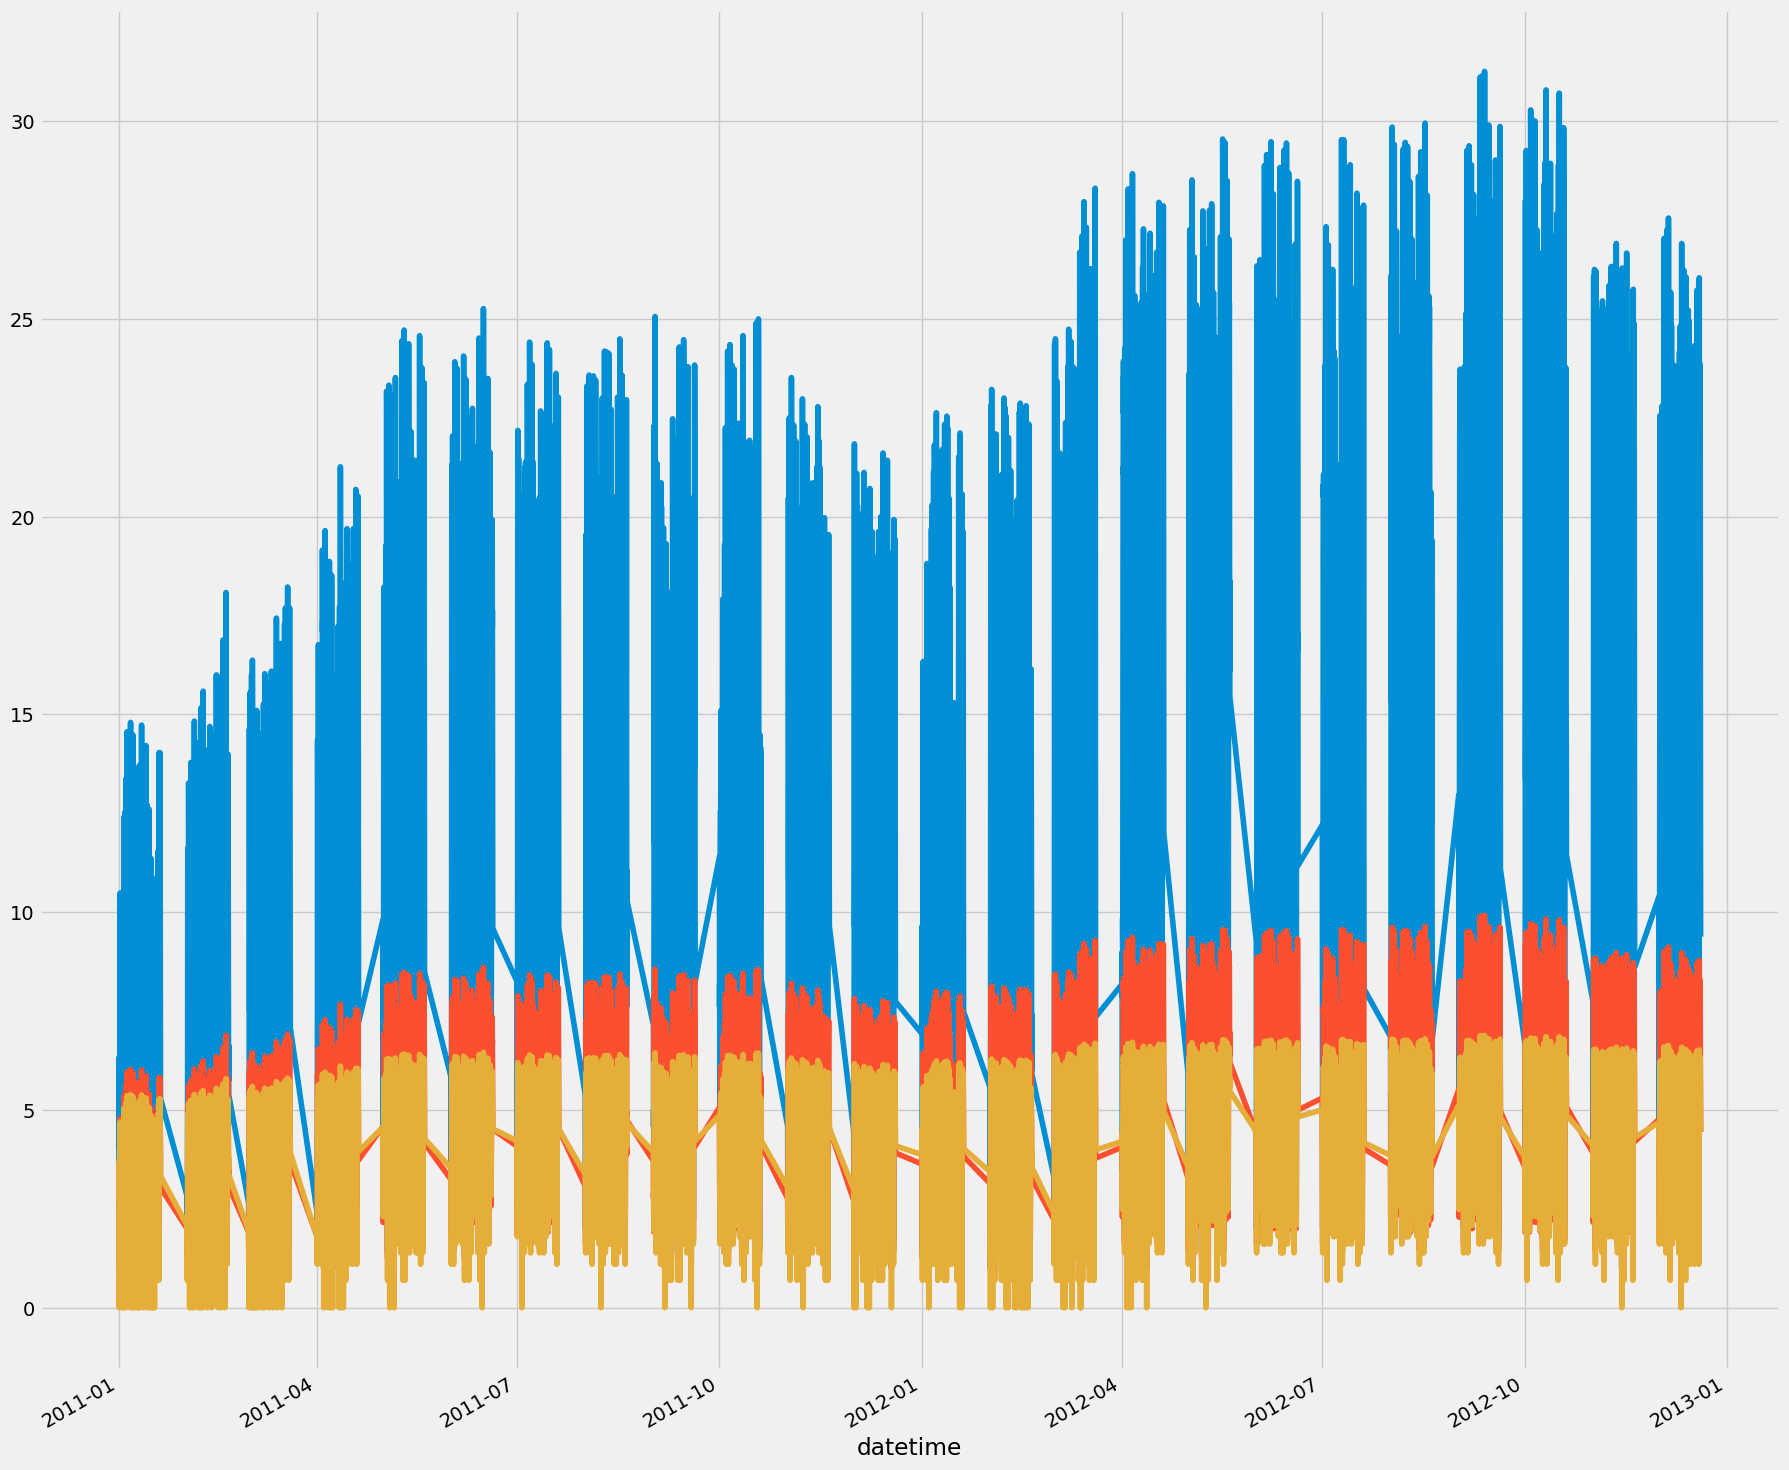

In [66]:
bikes_df['y_sqrt'].plot();
bikes_df['y_cbrt'].plot();
bikes_df['y_log'].plot();

**Modify our function to accept transformations**

In [67]:
def train_test_rmse_transform(df, feature_cols, response, transformation):
    """Compute RMSE for models of transformed targets """
    X = df[feature_cols]
    y = df[response]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    if transformation == 'sqrt':
        y_pred_sqrt = linreg.predict(X_test)
        y_pred = np.square(y_pred_sqrt)
    elif transformation == 'log':
        y_pred_log = linreg.predict(X_test)
        y_pred = np.exp(y_pred_log)
    elif transformation == 'cbrt':
        y_pred_cbrt = linreg.predict(X_test)
        y_pred = y_pred_cbrt**3
    return np.sqrt(mean_squared_error(y_test, y_pred))

**Check the RMSE of the square root transformation**

In [68]:
rmse_sqrt_1 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather', 'humidity'], 'y_sqrt', 'sqrt')
rmse_sqrt_2 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather'],'y_sqrt', 'sqrt')
rmse_sqrt_3 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'humidity'],'y_sqrt', 'sqrt')

print(f"['temp', 'season', 'weather', 'humidity'] RMSE: {rmse_sqrt_1}")
print(f"            ['temp', 'season', 'weather'] RMSE: {rmse_sqrt_2}")
print(f"           ['temp', 'season', 'humidity'] RMSE: {rmse_sqrt_3}")



['temp', 'season', 'weather', 'humidity'] RMSE: 175.2912301902021
            ['temp', 'season', 'weather'] RMSE: 159.47138577472992
           ['temp', 'season', 'humidity'] RMSE: 175.06673635120683


**Check the RMSE of the cube root transformation**

In [69]:
rmse_cbrt_1 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather', 'humidity'], 'y_cbrt', 'cbrt')
rmse_cbrt_2 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather'], 'y_cbrt', 'cbrt')
rmse_cbrt_3 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'humidity'], 'y_cbrt', 'cbrt')

print(f"['temp', 'season', 'weather', 'humidity'] RMSE: {rmse_cbrt_1}")
print(f"            ['temp', 'season', 'weather'] RMSE: {rmse_cbrt_2}")
print(f"           ['temp', 'season', 'humidity'] RMSE: {rmse_cbrt_3}")

['temp', 'season', 'weather', 'humidity'] RMSE: 173.96307559461596
            ['temp', 'season', 'weather'] RMSE: 153.40772772069866
           ['temp', 'season', 'humidity'] RMSE: 173.57920137042606


**Check the RMSE of the log transformation**

In [70]:
rmse_log_1 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather', 'humidity'], 'y_log', 'log')
rmse_log_2 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'weather'],'y_log', 'log')
rmse_log_3 = train_test_rmse_transform(bikes_df, ['temp', 'season', 'humidity'],'y_log', 'log')

print(f"['temp', 'season', 'weather', 'humidity'] RMSE: {rmse_log_1}")
print(f"            ['temp', 'season', 'weather'] RMSE: {rmse_log_2}")
print(f"           ['temp', 'season', 'humidity'] RMSE: {rmse_log_3}")

['temp', 'season', 'weather', 'humidity'] RMSE: 167.01676247215437
            ['temp', 'season', 'weather'] RMSE: 126.95160067133287
           ['temp', 'season', 'humidity'] RMSE: 165.6422472938903


**Append the model scores to the original dataset**

In [71]:
X = bikes_df[['temp', 'season', 'weather']]
y = bikes_df['y_log']
    
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Instantiate
linreg = LinearRegression()

# Fit
linreg.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [72]:
# Predict
bikes_df['y_pred_log']= np.exp(linreg.predict(X))

In [73]:
bikes_df.head(50)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred,y_sqrt,y_cbrt,y_log,y_pred_log
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,16.965417,4.000000,2.519842,2.772589,42.594240
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,13.390450,6.324555,3.419952,3.688879,40.264981
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,13.390450,5.656854,3.174802,3.465736,40.264981
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,35.108975,3.605551,2.351335,2.564949,42.594240
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,35.108975,1.000000,1.000000,0.000000,42.594240
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,35.108975,1.000000,1.000000,0.000000,35.386106
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,13.390450,1.414214,1.259921,0.693147,40.264981
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,-11.352001,1.732051,1.442250,1.098612,38.063097
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,35.108975,2.828427,2.000000,2.079442,42.594240


**Create a baseline/null model result to compare your models.**

In [ ]:
# Create X and y.


# Split X and y into training and testing sets.


# Create a NumPy array with the same shape as y_test.


# Fill the array with the mean value of y_test.


# Compute null RMSE.


**Compare the single variable and multiple variable models using the `train_test_rmse` function.**

**Which model is better?**

**Why is the RMSE significantly lower than the RMSE in the bikes model?**

**Square root transform the Score variable and compare the RMSE using the `train_test_rmse_transform` function.**

In [ ]:
#Show distribution

In [ ]:
#Calculate RMSE and compare to baseline

**What would you recommend?**

<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [74]:
bikes_df.tail(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred,y_sqrt,y_cbrt,y_log,y_pred_log
datetime,,,,,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,223.444360,18.330303,6.952053,5.817111,86.623122
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,195.677983,15.524175,6.223084,5.484797,81.886150
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,176.983384,12.961481,5.517848,5.123964,77.408219
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,176.983384,11.357817,5.052774,4.859812,77.408219
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,155.264860,9.380832,4.447960,4.477337,73.175163


In [75]:
# Use get_dummies to transform categorical features into one-hot encoded data

season_dummies = pd.get_dummies(bikes_df['season'], prefix='season')

season_dummies.tail()

,season_1,season_2,season_3,season_4
datetime,,,,
2012-12-19 19:00:00,False,False,False,True
2012-12-19 20:00:00,False,False,False,True
2012-12-19 21:00:00,False,False,False,True
2012-12-19 22:00:00,False,False,False,True
2012-12-19 23:00:00,False,False,False,True


#### Inspect the `DataFrame` of `dummies`.

In [76]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,False,False,True,False
2012-03-18 04:00:00,True,False,False,False
2012-10-14 17:00:00,False,False,False,True
2011-04-04 15:00:00,False,True,False,False
2012-12-11 02:00:00,False,False,False,True


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

#### Drop the first column.

In [77]:
# drop the first column
#season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# Redo the get_dummies command and use 'drop_first' to drop the first dummy column.
season_dummies = pd.get_dummies(bikes_df['season'], prefix='season', drop_first=True)

season_dummies.head()

,season_2,season_3,season_4
datetime,,,
2011-01-01 00:00:00,False,False,False
2011-01-01 01:00:00,False,False,False
2011-01-01 02:00:00,False,False,False
2011-01-01 03:00:00,False,False,False
2011-01-01 04:00:00,False,False,False


#### Reinspect the `DataFrame` of `dummies`.

In [78]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,False,True,False
2012-03-18 04:00:00,False,False,False
2012-10-14 17:00:00,False,False,True
2011-04-04 15:00:00,True,False,False
2012-12-11 02:00:00,False,False,True


In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [79]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes_df, season_dummies], axis=1)

# Print 5 random rows.
bikes_dummies.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred,y_sqrt,y_cbrt,y_log,y_pred_log,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,234.270753,17.549929,6.753313,5.730100,159.263650,False,True,False
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,37.044409,3.741657,2.410142,2.639057,58.700685,False,False,False
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,327.373524,23.216374,8.138223,6.289716,179.944151,False,False,True
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,386.106017,11.958261,5.229322,4.962845,204.235760,True,False,False
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,181.660431,1.000000,1.000000,0.000000,76.127070,False,False,True


#### Rerun the linear regression with dummy variables included.

In [80]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

# Instantiate
linreg = LinearRegression()

# Fit
linreg.fit(X, y)

# display the coefficients along with their names
list(zip(feature_cols, linreg.coef_))

[('temp', np.float64(11.186405863575818)),
 ('season_2', np.float64(-3.39054309971813)),
 ('season_3', np.float64(-41.73686071317102)),
 ('season_4', np.float64(64.415961468242)),
 ('humidity', np.float64(-2.81948163625964))]

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have the dummy that is your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [81]:
# Compare original season variable with dummy variables.
rmse_dummy_1 = train_test_rmse(bikes_dummies, ['temp', 'season', 'humidity'],'total_rentals')
rmse_dummy_2 = train_test_rmse(bikes_dummies, ['temp', 'season_2', 'season_3', 'season_4', 'humidity'],'total_rentals')

print(f"['temp', 'season', 'humidity'] RMSE: {rmse_dummy_1}")
print(f"['temp', 'season_2', 'season_3', 'season_4', 'humidity'] RMSE: {rmse_dummy_2}")

['temp', 'season', 'humidity'] RMSE: 155.59818936691417
['temp', 'season_2', 'season_3', 'season_4', 'humidity'] RMSE: 154.33394593635998


### Exercises
#### 4. Bike Weather Dummy Variables
Build dummy variables for weather, append it to the `bike_dummies` dataframe, and check the model performance with both `total rentals` and the log transformation, using `temp`, `season` and `weather`. Use the `drop_first=True` parameter in `pd.get_dummies`.

Once complete, check the results of the log transformation just using `temp` as a variable.

In [ ]:
#Calculate RMSE


In [ ]:
#Log transform y


In [ ]:
#Build the model


In [ ]:
#Compare RMSE with dummy variables and temp only model

In [ ]:
#Temp only model


**What are your conclusions?**

<a id="feature-engineering"></a>
### More Feature Engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature.

In [ ]:
bikes_df['hour'] = bikes_df.index.hour

#### Encode `hour` as a categorical feature.

In [ ]:
# One-hot encode the hour feature
hour_dummies = pd.get_dummies(bikes_df.hour, prefix='hour',drop_first=True)
bikes_df = pd.concat([bikes_df, hour_dummies], axis=1)

#### Generate a `daytime` variable based on hour of the day.

In [ ]:
# Tip - use conditions to set a value that identifies day vs night (think sunrise to sunset?)
bikes_df['daytime'] = ((bikes_df.hour > 6) & (bikes_df.hour < 19)).astype(int)

In [ ]:
bikes_df.head(2).T

#### Test the root mean squared error of our various `hour` encodings.

In [ ]:
# Remember we built the function train_test_rmse()
rmse_hour = train_test_rmse(bikes_df, ['hour'], ['total_rentals'])
rmse_hourly = train_test_rmse(bikes_df, bikes_df.columns[bikes_df.columns.str.startswith('hour_')],['total_rentals'])
rmse_daytime = train_test_rmse(bikes_df, ['daytime'],['total_rentals'])

print(f'Hourly RMSE: {rmse_hour}')
print(f'Hourly RMSE: {rmse_hourly}')
print(f'Daytime RMSE: {rmse_daytime}')

### Bike Share Bonus: Building models for other y variables

We've completely a model together that explains total rides. Now it's your turn to build another model, using a different y variable: registered riders.

#### Pay attention to:

* the distribution of riders (should we rescale the data?)  
* checking correlations with variables and registered riders  
* having a feature space (our matrix) with low multicollinearity  
* model complexity vs explanation of variance: at what point do features in a model stop improving r-squared?  
* the linear assumption -- given all feature values being 0, should we have no ridership? negative ridership? positive ridership?

 

In [ ]:
# Create dummy variables


# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).



In [ ]:
#Calculate RMSE


**You have the hypothesis that your model may be different by season.  What if you built a model for just Mar-May period of stay? Compare using just `Hotel stars` vs. `Hotel stars` and the traveler type dummy variables.**

In [ ]:
#Subset Mar-May Period of stay and use in the train_test_rmse_transform function


**Can you compare the RMSE between the seasonal model vs. the entire dataset? What is your conclusion about all of the model results?  What are your next steps?**

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']

X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [ ]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

While the MSE barely changed, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.  

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.